In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

# データロード

In [3]:
year2016 = pd.read_csv("data/enshu2.csv", names=["date", "count"], infer_datetime_format=True, parse_dates=[0])

In [4]:
year2016.head()

,date,count
0,2016-01-01,14009
1,2016-01-02,14342
2,2016-01-03,14411
3,2016-01-04,15347
4,2016-01-05,15427


In [5]:
first_half = year2016[year2016["date"] < "2016/07/01"]

In [6]:
first_half.head()

,date,count
0,2016-01-01,14009
1,2016-01-02,14342
2,2016-01-03,14411
3,2016-01-04,15347
4,2016-01-05,15427


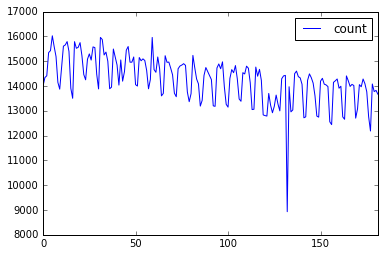

In [7]:
first_half.plot()

In [8]:
second_half = year2016["2016/07/01" <= year2016["date"]]

In [9]:
train_second = second_half[second_half["date"] < "2016/12/01"]
test_second = second_half["2016/12/01" <= second_half["date"]]

In [10]:
first_half.to_csv("data/pretraining_enshu2.csv")
train_second.to_csv("data/train_enshu2.csv")
test_second.to_csv("data/test_enshu2.csv")

# 学習済みモデルを作る

## データの正規化

In [11]:
from sklearn.preprocessing import MinMaxScaler

In [12]:
diff_ma_train = first_half[["count"]] - first_half[["count"]].rolling(7).mean()

In [13]:
diff_ma_train.dropna(inplace=True)

In [14]:
diff_ma_train.head()

,count
6,565.142857
7,-1.285714
8,-1014.428571
9,-1211.571429
10,-257.857143


In [15]:
scaler = MinMaxScaler(feature_range=(-1, 1))

In [16]:
train = scaler.fit_transform(diff_ma_train)

データを短い単位に分割(並列処理のため)

In [17]:
train.shape

(176, 1)

In [18]:
xs = []
i = 0
while i + 21 <= train.shape[0]:
    xs.append(train[i:i + 21])
    i += 14
xs = np.array(xs)

In [19]:
xs.shape

(12, 21, 1)

予測値を作成

In [20]:
ys = []
i = 1
while i + 21 <= train.shape[0]:
    ys.append(train[i:i + 21])
    i += 14
ys = np.array(ys)

In [21]:
ys.shape

(12, 21, 1)

# モデルを構築

In [22]:
from keras.models import Sequential
from keras.layers import Dense, TimeDistributed, LSTM, Activation, Dropout

Using Theano backend.
Using gpu device 0: GRID K2 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5110)
/opt/anaconda/lib/python3.5/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [23]:
model = Sequential()
model.add(LSTM(input_dim=1, output_dim=50, return_sequences=True))
model.add(Dropout(0.5))
model.add(Activation("tanh"))
model.add(LSTM(output_dim=10, return_sequences=True))
model.add(Dropout(0.5))
model.add(Activation("tanh"))
model.add(TimeDistributed(Dense(output_dim=5)))
model.add(Dropout(0.5))
model.add(Activation("relu"))
model.add(TimeDistributed(Dense(output_dim=1, activation="tanh")))
model.compile(loss="mean_squared_error", optimizer="adam")

In [24]:
%%time
history = model.fit(xs, ys, nb_epoch=50000, validation_split=0.1, verbose=0)

CPU times: user 23min 9s, sys: 3min 20s, total: 26min 30s
Wall time: 26min 28s


# 保存

In [25]:
import json

In [26]:
with open("data/pretrain_logs_enshu2.json", "w") as fp:
    fp.write(json.dumps(history.history))

In [27]:
model.save("data/pretrain_enshu2.h5")

# lossの推移を見る

In [28]:
history.history.keys()

dict_keys(['val_loss', 'loss'])

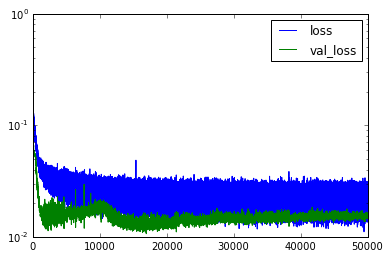

In [31]:
pd.DataFrame(history.history).plot(logy=True)